# Reference mapping - example
This notebooks shows how a preprocessed query (described below) can be mapped on our mouse scRNA-seq pancreatic islet atlas using scArches.

In [1]:
import scanpy as sc
import pandas as pd
import pickle
import datetime
import os
import numpy as np
import json
from scipy import sparse

import scarches as sca

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
from matplotlib import colors as mcolors

Using TensorFlow backend.
/home/icb/karin.hrovatin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/icb/karin.hrovatin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/icb/karin.hrovatin/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/icb/karin.hrovatin/.loc

## Reference

### Model parameters
Prepare parameters that were used in the reference model.

In [2]:
# Load parameters of the reference model
params=pickle.load(open('../data/scArches/params.pkl','rb'))
print('Reference params:',params)

Reference params: {'z_dimension': 15, 'architecture': [128, 128, 128], 'task_name': 'run_scArches1603792372.695119', 'x_dimension': 2000, 'beta': 0.0, 'alpha': 0.99, 'loss_fn': 'sse', 'n_epochs': 150, 'batch_size': 128, 'subset_beta': False, 'hvg_n': '2000', 'input_file_name': 'data_normlisedForIntegration.h5ad'}


### Reference data
Prepare reference data for re-loading of the model.

In [3]:
# Load the reference data
adata_ref=sc.read('../data/scRNA/adata_ref.h5ad')
adata_ref

AnnData object with n_obs × n_vars = 0 × 13999
    obs: 'batch_integration'
    var: 'gene_symbol', 'used_integration', 'gene_symbol_original_matched'

Prepare features (genes) in accordance with the pre-trained scArches model.

In [4]:
# Genes used in the model
used_genes=json.load(open('../data/scArches/scArches.json','r'))['gene_names']
# Subset reference data to the used genes and re-order gene names as used in the model
eid_map=dict(zip(adata_ref.var.gene_symbol_original_matched,adata_ref.var_names))
used_eids=[eid_map[g] for g in used_genes]
adata_ref=adata_ref[:,used_eids]
adata_ref

View of AnnData object with n_obs × n_vars = 0 × 2000
    obs: 'batch_integration'
    var: 'gene_symbol', 'used_integration', 'gene_symbol_original_matched'

### Restore model
Restore the reference model so that it can be later adapted for mapping of the query.

In [5]:
# Restore the reference model
network = sca.models.scArches(
    task_name='scArches',
    x_dimension=params['x_dimension'],
    z_dimension=params['z_dimension'],
    architecture=params['architecture'],
    gene_names=adata_ref.var_names.tolist(),
    conditions=json.load(open('../data/scArches/scArches.json','r'))[ 'conditions'],
    alpha=params['alpha'], 
    beta=params['beta'],
    loss_fn=params['loss_fn'],
    # Strip task name from model dir as this is appended within network
    model_path='../data/', 
    )






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
scArches' network has been successfully constructed!

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
scArches' network has been successfully compiled!


In [6]:
# Make sure that model exists before training 
# (if model does not exist it will try to retrain)
if not os.path.exists(os.path.join(network.model_path, f"{network.model_name}.h5")):
    raise ValueError('Model path not found:',
                     os.path.join(network.model_path, f"{network.model_name}.h5"))

In [7]:
# Reload model weights
network.train(adata_ref,
              condition_key='batch_integration',
              retrain=False,
              n_epochs=params['n_epochs'],
              batch_size=params['batch_size'],
              save=False
             )

scArches' network has been successfully compiled!
cvae's weights has been successfully restored!


## Query

### Query data
We recomend use of UMI-based scRNA-seq queries (query mapping was not tested on full-length scRNA-seq datasets). Query data (saved in AnnData h5ad format) should contain normalised expression in X (per-sample normalisation with Scran followed by log(x+1) transformation). Genes should be specified as Ensembl IDs in var_names. Each sample should be one batch, here we specify it in obs column batch_integration.

In [8]:
# Load query data
adata_query=sc.read('../data/scRNA/adata_query.h5ad')

Here we map query features (genes) to match the reference model. This is based on Ensembl IDs in var. If a gene used in the model is missing from the query it is asigned 0-expression across all cells.

In [9]:
# Remap query features (genes) to match the reference model

# Map from query to integration space
vals=[]
rows=[]
cols=[]
eid_mm_map=dict(zip(adata_ref.var_names,range(adata_ref.shape[1])))
for row,eid_mm in enumerate(adata_query.var_names):
    if eid_mm in eid_mm_map:
        col=eid_mm_map[eid_mm]
        vals.append(1)
        rows.append(row)
        cols.append(col)
gene_inetgration_map=sparse.csr_matrix(
    (np.array(vals), (np.array(rows), np.array(cols))), 
    shape=(adata_query.shape[1], adata_ref.shape[1]))

# Subset data to query genes
adata_query=sc.AnnData(
    sparse.csr_matrix(adata_query.X)@gene_inetgration_map,
    obs=adata_query.obs,
    var=adata_ref.var[['gene_symbol', 'used_integration', 'gene_symbol_original_matched']])
adata_query.X = np.asarray(adata_query.X.todense())
print('Integration data shape:',adata_query.shape) 

Integration data shape: (2741, 2000)


# TODO report missing genes

### Query mapping
In this section we extend the reference scArches model for query mapping and obtain the latent embedding of the query.

#### Train the query model

The query data (model, parameters, and latent representation) will be saved to the data directory within a subdirectory as specified in the updated parameters under task_name in the format: mapref_scArches*TIMESTAMP*

In [10]:
# Change model parameters for mapping
params_new=params.copy()
params_new['task_name']='mapref_scArches'+str(datetime.datetime.now().timestamp())
params_new['task_name_atlas']=params['task_name']
params_new['sca_version']='scArches'
del params_new['input_file_name']
print('Mapping params',params_new)

Mapping params {'z_dimension': 15, 'architecture': [128, 128, 128], 'task_name': 'mapref_scArches1662807184.670472', 'x_dimension': 2000, 'beta': 0.0, 'alpha': 0.99, 'loss_fn': 'sse', 'n_epochs': 150, 'batch_size': 128, 'subset_beta': False, 'hvg_n': '2000', 'task_name_atlas': 'run_scArches1603792372.695119', 'sca_version': 'scArches'}


In [11]:
# Saving path for the mapping results
path_save='../data/'+params_new['task_name']+'/'
path_save

'../data/mapref_scArches1662807184.670472/'

In [12]:
# Make query mapping model
network_new = sca.operate(
    network,
    new_task_name=params_new['task_name'],
    new_conditions=adata_query.obs['batch_integration'].unique().tolist(),
    version=params_new['sca_version']
    )
network_new.model_path=path_save

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!
scArches' network has been successfully compiled!


In [13]:
# Train the query mapping model
network_new.train(adata_query,
          condition_key='batch_integration',
          retrain=True,
          n_epochs=params_new['n_epochs'],
          batch_size=params_new['batch_size'],
          save=True
          )   

 |█████████████-------| 65.3%  - loss: 75.9089 - mmd_loss: 0.0000 - recon_loss: 75.9089 - val_loss: 576.7666 - val_mmd_loss: 0.0000 - val_recon_loss: 576.7666Training stopped with Early Stopping

scArches has been successfully saved in ../data/mapref_scArches1662807184.670472/.


In [14]:
# Save params
pickle.dump(params_new,open(path_save+'params.pkl','wb'))

#### Latent representation of the query

In [15]:
# Get query latent representation
latent_query = network_new.get_latent(adata_query, 'batch_integration')

In [16]:
# Save query representation
latent_query.write(path_save+'latent_query.h5ad')

### Analyse query mapping
Compare latent embeding of the query to the atlas reference (here we use a subset of the full atlas data). This part of the script needs to be adapted for other datasets as it relies on plotting of specific metadata columns persent in our datasets. Here we use only obs columns that do not share column names between query and reference. 

In [17]:
# Load reference subset embedding
latent_ref=sc.read('../data/scRNA/adata_ref_latent.h5ad')
# Merge query and reference into single adata
latent=sc.AnnData.concatenate(latent_ref,latent_query,
                       batch_categories =['ref','query'],batch_key='ref_query')

In [18]:
# Compute the joined umap 
sc.pp.neighbors(latent,use_rep='X')
sc.tl.umap(latent)

Embedding of reference and query. 

Query plotted on top (achieved by the concatenation order and thus cell order).

... storing 'dataset' as categorical
... storing 'cell_type_reannotatedIntegrated' as categorical
... storing 'cell_subtype_beta_coarse_reannotatedIntegrated' as categorical
... storing 'diabetes_model' as categorical
... storing 'chemical_stress' as categorical
... storing 'strain' as categorical
... storing 'STZ' as categorical
... storing 'insulin_implant' as categorical
... storing 'time_after_STZ' as categorical
... storing 'age' as categorical
... storing 'cell_type_original' as categorical
... storing 'cell_subtype_original' as categorical
... storing 'cell_type' as categorical
... storing 'donor' as categorical
... storing 'sex' as categorical
... storing 'disease' as categorical
... storing 'batch_integration' as categorical


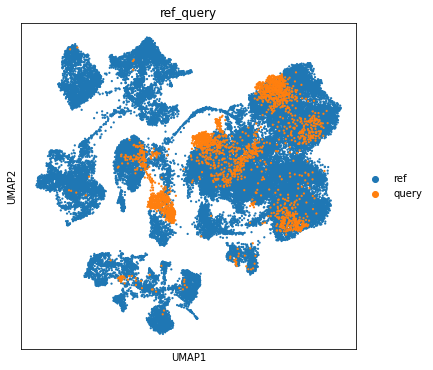

In [19]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(latent,color='ref_query',s=20)

Cell type plots for reference and query, plotting the other subset as background (gray).

The query cell type is specified in a column cell_type. Alternatively, one could also try cell type or state transfer from the atlas (see for example the paper reproducibility notebooks). However, for this we recomend the use of the whole reference data (not only a subset as used here), which can be downloaded from GEO as specified in the mmanuscript.

In [33]:
# Make matched color palette for cell types across reference and query
colors=['tab:blue',  'tab:orange','tab:green','tab:red', 'tab:purple',
        'tab:brown','tab:pink', 'tab:olive','tab:cyan',
        'bisque','limegreen','lightcoral','plum',
        'peru','pink','yellowgreen','paleturquoise','yellow',
        'gold','brown','navy','forestgreen','lime','lightsalmon','teal','olive']
cell_types_all=set(latent.obs['cell_type'])|set(latent.obs['cell_type_reannotatedIntegrated'])
ct_cmap=dict(zip(cell_types_all,colors[:len(cell_types_all)]))
latent.uns['cell_type_colors']=[ct_cmap[ct] for ct in latent.obs['cell_type'].cat.categories]
latent.uns['cell_type_reannotatedIntegrated_colors']=[
    ct_cmap[ct] for ct in latent.obs['cell_type_reannotatedIntegrated'].cat.categories]

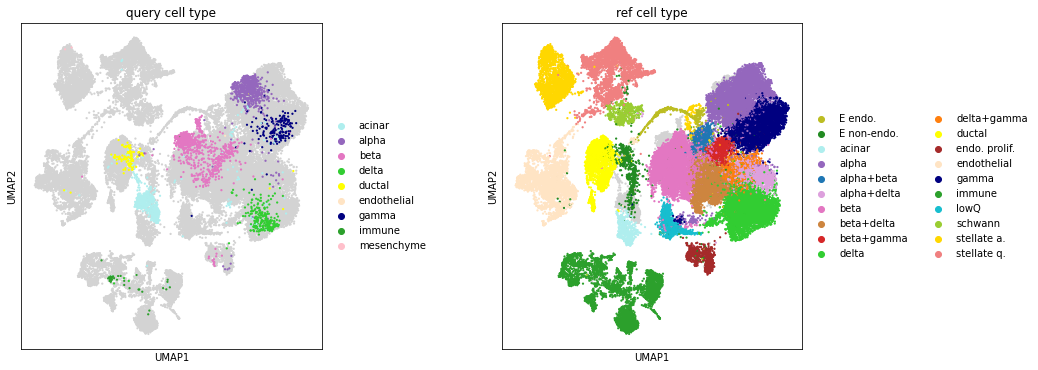

In [34]:
# Plot cell types for reference and query
fig,axs=plt.subplots(1,2,figsize=(14,6))
for ax,rq, ct in [
    (axs[0],'query','cell_type'),
    (axs[1],'ref','cell_type_reannotatedIntegrated')]:
    sc.pl.umap(latent[latent.obs.ref_query!=rq,:],ax=ax,show=False,s=20)
    sc.pl.umap(latent[latent.obs.ref_query==rq,:],ax=ax,color=ct,title=rq+' cell type',
               show=False,s=20)
plt.subplots_adjust(wspace=0.6)

Background is plotted in light gray.

Comparison of reference mapping on the level of beta cell states, using only beta cells from reference and query.

In [70]:
# Subset to beta cells
latent_beta=latent[(latent.obs.cell_type=="beta")|
                   (latent.obs.cell_type_reannotatedIntegrated=="beta"),:].copy()

In [71]:
# Recompute umap on beta cell only
sc.pp.neighbors(latent_beta,use_rep='X')
sc.tl.umap(latent_beta)

Beta cell state plots for reference and query, plotting the other data subset as a background (gray).

In [72]:
# Edit query age data for plotting
# Order query ages for plotting
latent_beta.obs['age']=pd.Categorical(values=latent_beta.obs['age'],ordered=True,
    categories=['nan','3 d', '12 d', '21 d', '2 m','2.2 m', '2.4 m', '2.77 m',
                '3 m','3.4 m','4 m', '7 m','11 m'])
# Add continous colors to ages
cmap = cm.get_cmap('gnuplot')
latent_beta.uns['age_colors']=['lightgray']+[
    mcolors.to_hex(cmap(i))  for i in np.linspace(0, 1, latent_beta.obs['age'].nunique()-1)]

In [73]:
# Make query category for insulin implat and STZ treatment
latent_beta.obs['diabetes_model']=pd.Categorical([
    'nan' if rq=='ref' else 'healthy' if stz=='False' else 'STZ' if ins=="False" else 'STZ+ins'
    for stz, ins, rq in 
    zip(latent_beta.obs.STZ,latent_beta.obs.insulin_implant,latent_beta.obs.ref_query)],
    categories=['nan','STZ','STZ+ins','healthy'],ordered=True)
# Specify colors to use for each category
latent_beta.uns['diabetes_model_colors']=['lightgray','tab:red','goldenrod','tab:green']

Trying to set attribute `.uns` of view, copying.


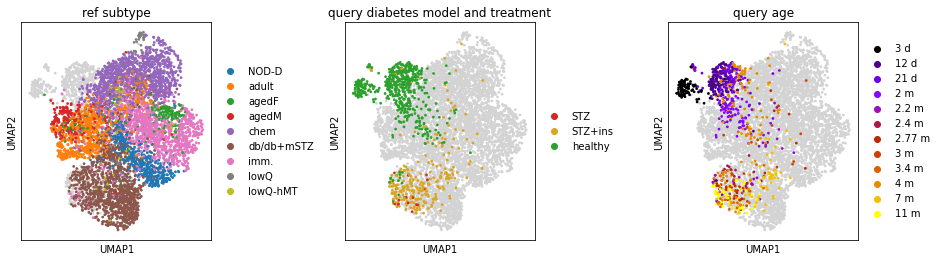

In [74]:
# Plot beta cell states in reference and query
fig,axs=plt.subplots(1,3,figsize=(15,4))
for ax,rq, ct,t in [
    (axs[0],'ref','cell_subtype_beta_coarse_reannotatedIntegrated','subtype'),
    (axs[1],'query','diabetes_model','diabetes model and treatment'),
    (axs[2],'query','age','age')]:
    sc.pl.umap(latent_beta[latent_beta.obs.ref_query!=rq,:],ax=ax,show=False,s=30)
    sc.pl.umap(latent_beta[latent_beta.obs.ref_query==rq,:],ax=ax,color=ct,title=rq+' '+t,
               show=False,s=30)
plt.subplots_adjust(wspace=0.7)

As expected, query beta cells treated with STZ map onto T2D model cells from the reference and healthy query cells map alongside non-diabetic reference clusters. Similarly, the youngest (3 days old) query cells map further away from the reference beta cells as they are all older (youngest reference sample is 16 days old). Additionally, as explained in the manuscript, we observed that the reference immature subtype differs from the young query cells (12 or 21 days).